In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import BinaryAccuracy
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import f1_score, confusion_matrix, classification_report, roc_curve, auc, accuracy_score, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE, RandomOverSampler, ADASYN

In [2]:
dataset = pd.read_csv("ad_click_dataset.csv")
dataset.head()


,id,full_name,age,gender,device_type,ad_position,browsing_history,time_of_day,click
0,670,User670,22.0,NaN,Desktop,Top,Shopping,Afternoon,1
1,3044,User3044,NaN,Male,Desktop,Top,NaN,NaN,1
2,5912,User5912,41.0,Non-Binary,NaN,Side,Education,Night,1
3,5418,User5418,34.0,Male,NaN,NaN,Entertainment,Evening,1
4,9452,User9452,39.0,Non-Binary,NaN,NaN,Social Media,Morning,0


In [3]:
dataset.info()

dataset.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                10000 non-null  int64  
 1   full_name         10000 non-null  object 
 2   age               5234 non-null   float64
 3   gender            5307 non-null   object 
 4   device_type       8000 non-null   object 
 5   ad_position       8000 non-null   object 
 6   browsing_history  5218 non-null   object 
 7   time_of_day       8000 non-null   object 
 8   click             10000 non-null  int64  
dtypes: float64(1), int64(2), object(6)
memory usage: 703.3+ KB


,id,age,click
count,10000.000000,5234.000000,10000.000000
mean,5060.211400,40.197363,0.650000
std,2861.758265,13.126420,0.476993
min,5.000000,18.000000,0.000000
25%,2529.000000,29.000000,0.000000
50%,5218.000000,39.500000,1.000000
75%,7466.000000,52.000000,1.000000
max,10000.000000,64.000000,1.000000


In [4]:
dataset['gender'].value_counts()
dataset['device_type'].value_counts()
dataset['ad_position'].value_counts()
dataset['browsing_history'].value_counts()
dataset['time_of_day'].value_counts()

time_of_day
Morning      2126
Afternoon    2016
Evening      1958
Night        1900
Name: count, dtype: int64

In [5]:
dataset = dataset.drop(columns=['id','full_name'], axis=1)
dataset.shape

(10000, 7)

In [6]:
num_cols = dataset.select_dtypes(include=['float64', 'int64'])
cat_cols = dataset.select_dtypes(include=['object'])

print('Numeric Variables:')
print(num_cols.columns.tolist())

print("\nCategorical Variables:")
print(cat_cols.columns.tolist())

Numeric Variables:
['age', 'click']

Categorical Variables:
['gender', 'device_type', 'ad_position', 'browsing_history', 'time_of_day']


In [7]:
dataset.describe().T


,count,mean,std,min,25%,50%,75%,max
age,5234.0,40.197363,13.126420,18.0,29.0,39.5,52.0,64.0
click,10000.0,0.650000,0.476993,0.0,0.0,1.0,1.0,1.0


In [8]:
dataset.isnull().sum()

age                 4766
gender              4693
device_type         2000
ad_position         2000
browsing_history    4782
time_of_day         2000
click                  0
dtype: int64

In [9]:
dataset[dataset.isnull().any(axis=1)]

,age,gender,device_type,ad_position,browsing_history,time_of_day,click
0,22.0,NaN,Desktop,Top,Shopping,Afternoon,1
1,NaN,Male,Desktop,Top,NaN,NaN,1
2,41.0,Non-Binary,NaN,Side,Education,Night,1
3,34.0,Male,NaN,NaN,Entertainment,Evening,1
4,39.0,Non-Binary,NaN,NaN,Social Media,Morning,0
...,...,...,...,...,...,...,...
9994,NaN,Non-Binary,NaN,NaN,News,Morning,1
9995,NaN,NaN,Mobile,Top,Education,NaN,0
9996,NaN,Female,Desktop,Bottom,Entertainment,NaN,0
9997,NaN,Male,Mobile,Side,NaN,Morning,0


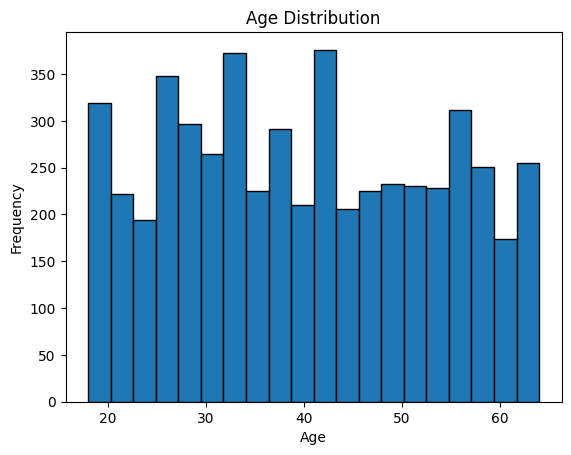

In [10]:
plt.hist(dataset['age'], bins=20, edgecolor='black')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

C:\Users\Juliano\AppData\Local\Temp\ipykernel_6836\975118693.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=dataset['click'], data=dataset, palette = "Set2")


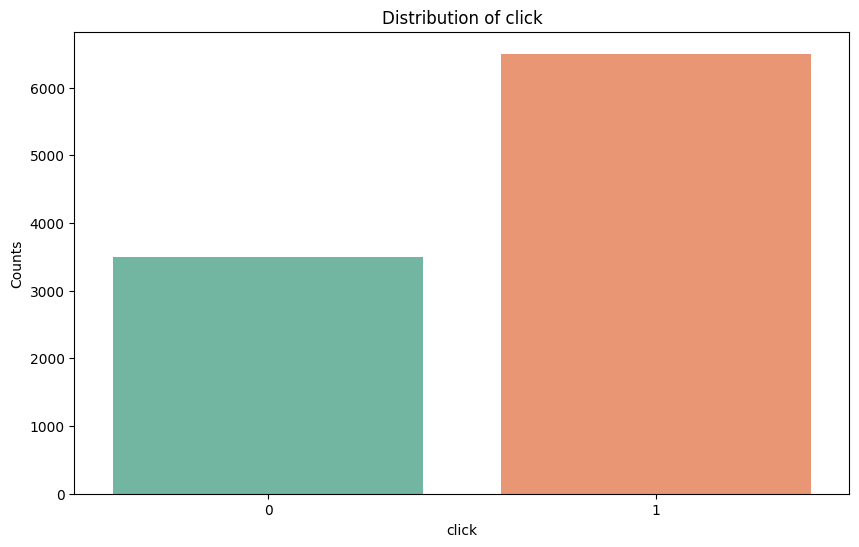

In [13]:
#cat=['click']
cor = sns.color_palette("Set2")
plt.figure(figsize=(10,6))
sns.countplot(x=dataset['click'], data=dataset, palette = "Set2")
plt.title(f'Distribution of click')
plt.xlabel('click')
plt.ylabel('Counts')
plt.show()

In [14]:
dataset['gender'] = dataset['gender'].fillna('Unknown')
dataset['device_type'] = dataset['device_type'].fillna('Unknown')
dataset['ad_position'] = dataset['ad_position'].fillna('Unknown')
dataset['browsing_history'] = dataset['browsing_history'].fillna('Unknown')
dataset['time_of_day'] = dataset['time_of_day'].fillna('Unknown')
dataset.head(10)

,age,gender,device_type,ad_position,browsing_history,time_of_day,click
0,22.0,Unknown,Desktop,Top,Shopping,Afternoon,1
1,NaN,Male,Desktop,Top,Unknown,Unknown,1
2,41.0,Non-Binary,Unknown,Side,Education,Night,1
3,34.0,Male,Unknown,Unknown,Entertainment,Evening,1
4,39.0,Non-Binary,Unknown,Unknown,Social Media,Morning,0
5,NaN,Non-Binary,Unknown,Bottom,Social Media,Evening,1
6,26.0,Female,Desktop,Top,Unknown,Unknown,1
7,40.0,Male,Mobile,Side,Unknown,Evening,0
8,NaN,Non-Binary,Mobile,Bottom,Social Media,Unknown,1
9,NaN,Unknown,Unknown,Bottom,Education,Afternoon,1


C:\Users\Juliano\AppData\Local\Temp\ipykernel_6836\1242272036.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=dataset, palette = "Set2")


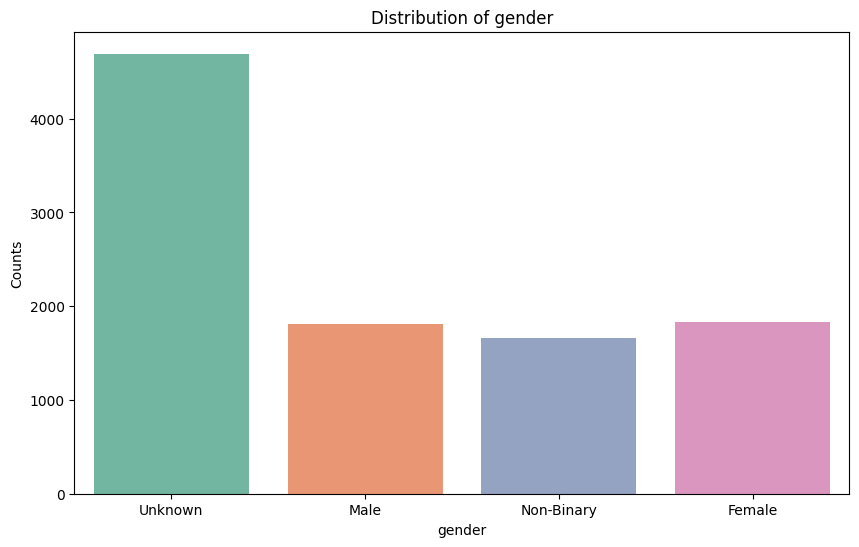

C:\Users\Juliano\AppData\Local\Temp\ipykernel_6836\1242272036.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=dataset, palette = "Set2")


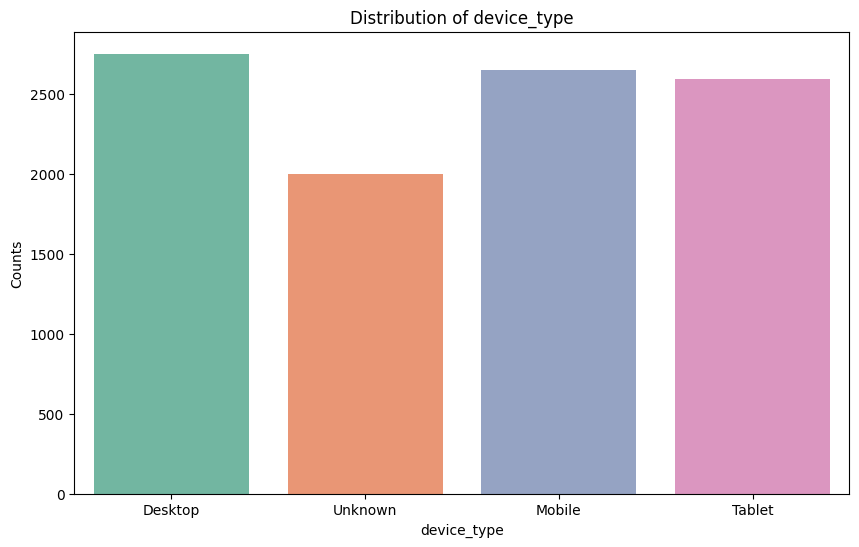

C:\Users\Juliano\AppData\Local\Temp\ipykernel_6836\1242272036.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=dataset, palette = "Set2")


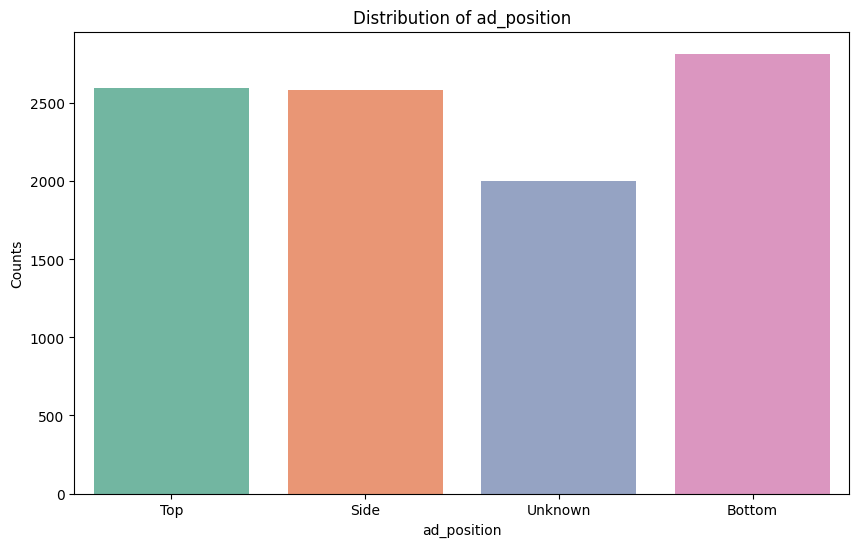

C:\Users\Juliano\AppData\Local\Temp\ipykernel_6836\1242272036.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=dataset, palette = "Set2")


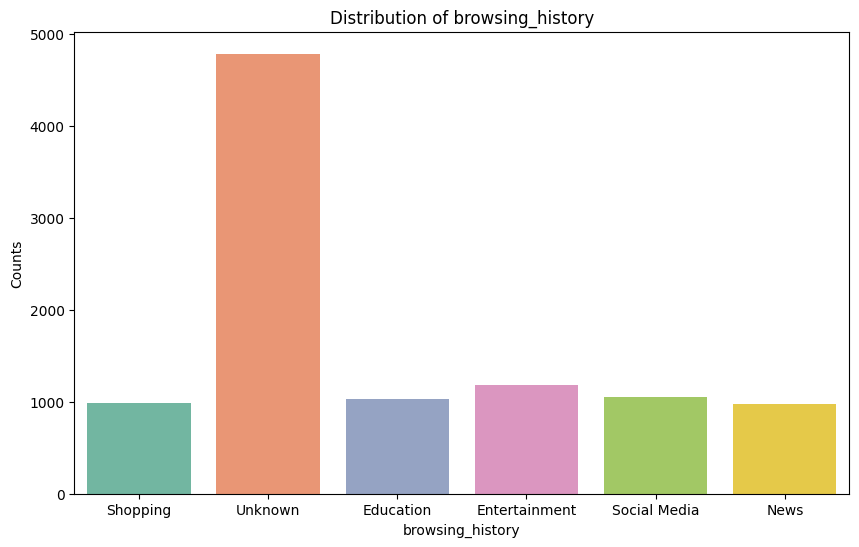

C:\Users\Juliano\AppData\Local\Temp\ipykernel_6836\1242272036.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=dataset, palette = "Set2")


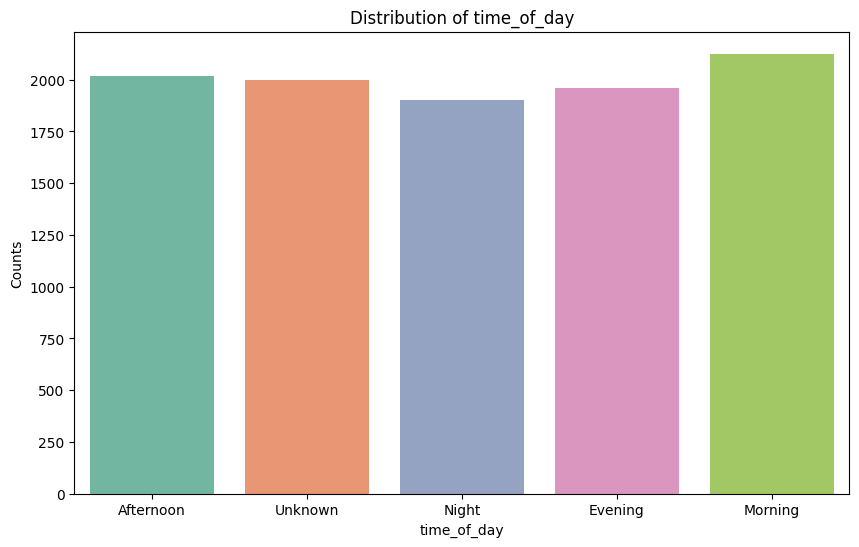

In [15]:
cat=['gender', 'device_type', 'ad_position', 'browsing_history', 'time_of_day']
cor = sns.color_palette("Set2")
for col in cat:
  plt.figure(figsize=(10,6))
  sns.countplot(x=col, data=dataset, palette = "Set2")
  plt.title(f'Distribution of {col}')
  plt.xlabel(col)
  plt.ylabel('Counts')
  plt.show()

In [16]:
def knn_impute(data, n_neighbors):   
    data_encoded = data.copy()
    
    category_mappings = {}
    for col in data_encoded.select_dtypes(include='object').columns:
        data_encoded[col] = data_encoded[col].astype('category').cat.codes
        category_mappings[col] = dict(enumerate(data[col].astype('category').cat.categories))

    knn_imputer = KNNImputer(n_neighbors=n_neighbors)
    data_imputed = pd.DataFrame(knn_imputer.fit_transform(data_encoded), columns=data_encoded.columns)

    for col in data.select_dtypes(include='object').columns:
        data_imputed[col] = data_imputed[col].round().astype(int).map(category_mappings[col])
        
    return data_imputed

data_imputed = knn_impute(dataset, n_neighbors=3)
data_imputed['age'] = np.floor(data_imputed['age'])
dataset = data_imputed
dataset.head(10)

,age,gender,device_type,ad_position,browsing_history,time_of_day,click
0,22.0,Unknown,Desktop,Top,Shopping,Afternoon,1.0
1,52.0,Male,Desktop,Top,Unknown,Unknown,1.0
2,41.0,Non-Binary,Unknown,Side,Education,Night,1.0
3,34.0,Male,Unknown,Unknown,Entertainment,Evening,1.0
4,39.0,Non-Binary,Unknown,Unknown,Social Media,Morning,0.0
5,48.0,Non-Binary,Unknown,Bottom,Social Media,Evening,1.0
6,26.0,Female,Desktop,Top,Unknown,Unknown,1.0
7,40.0,Male,Mobile,Side,Unknown,Evening,0.0
8,28.0,Non-Binary,Mobile,Bottom,Social Media,Unknown,1.0
9,38.0,Unknown,Unknown,Bottom,Education,Afternoon,1.0


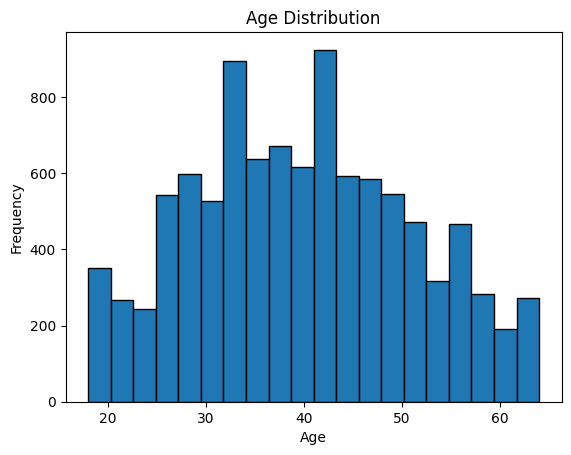

In [17]:
plt.hist(dataset['age'], bins=20, edgecolor='black')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

In [18]:
dataset.isnull().sum()

age                 0
gender              0
device_type         0
ad_position         0
browsing_history    0
time_of_day         0
click               0
dtype: int64

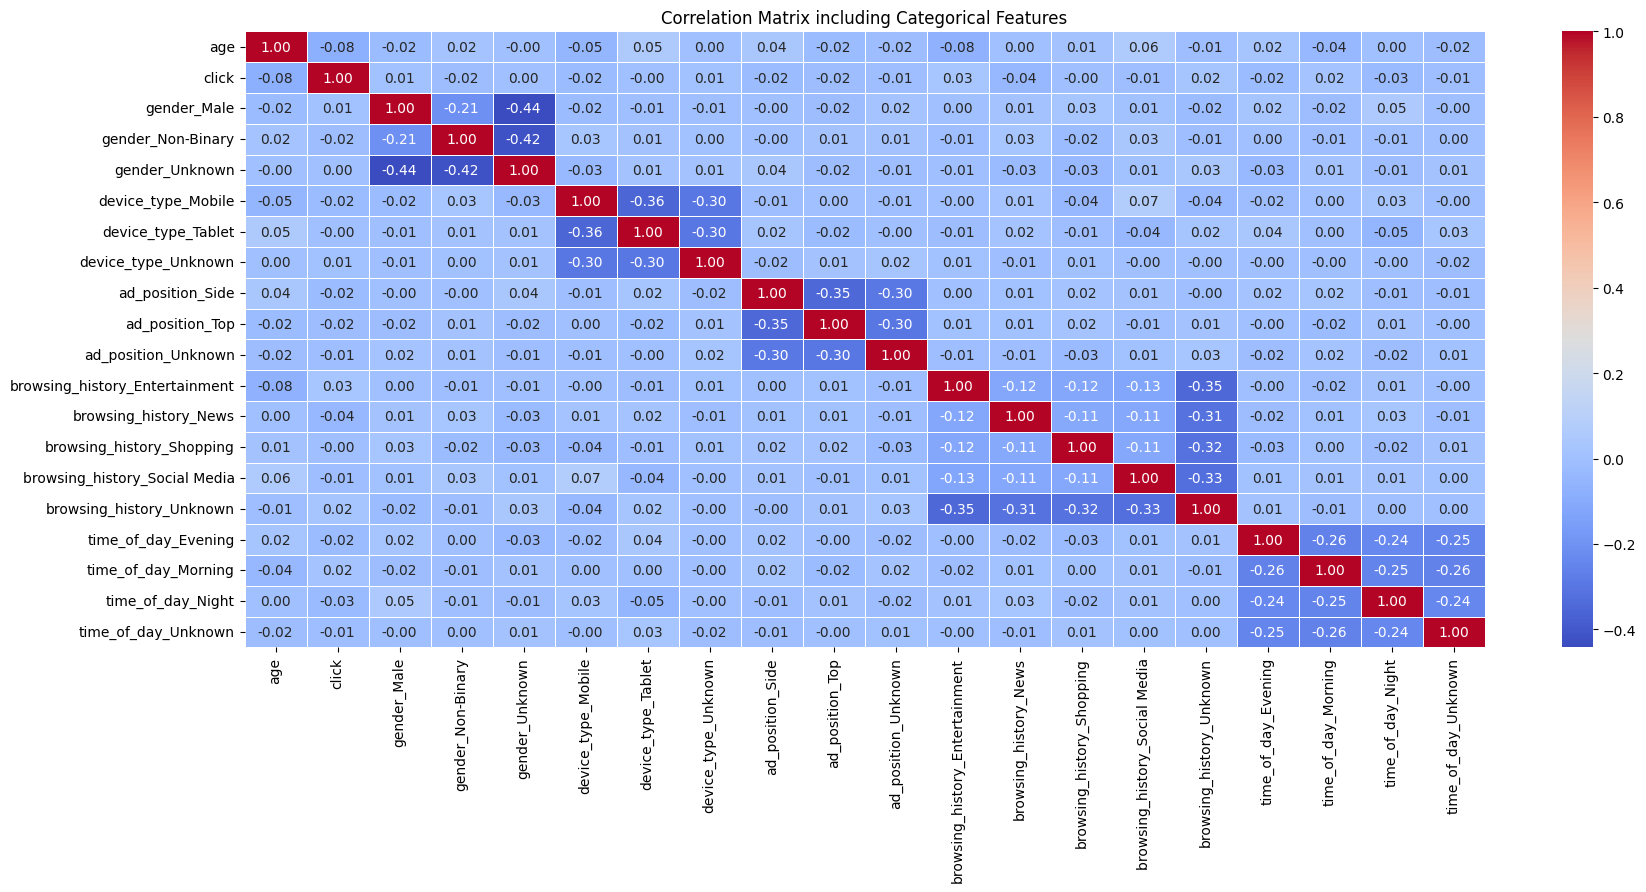

In [19]:
data_encoded = pd.get_dummies(dataset, drop_first=True)
corr_matrix = data_encoded.corr()

plt.figure(figsize=(20, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix including Categorical Features')
plt.show()

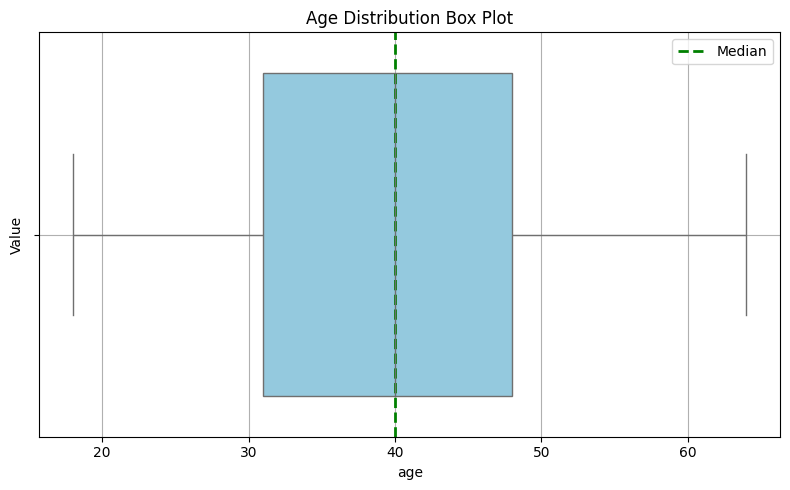

In [20]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=dataset, x="age", color='skyblue', flierprops=dict(marker='o', markersize=8, markerfacecolor='red'))
plt.title('Age Distribution Box Plot')
plt.xlabel('age')
plt.ylabel('Value')
median_age = dataset['age'].median()
plt.axvline(median_age, color='green', linestyle='--', linewidth=2, label='Median')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [21]:
x = dataset.iloc[:, :-1]
y = dataset.iloc[:, -1]
x

,age,gender,device_type,ad_position,browsing_history,time_of_day
0,22.0,Unknown,Desktop,Top,Shopping,Afternoon
1,52.0,Male,Desktop,Top,Unknown,Unknown
2,41.0,Non-Binary,Unknown,Side,Education,Night
3,34.0,Male,Unknown,Unknown,Entertainment,Evening
4,39.0,Non-Binary,Unknown,Unknown,Social Media,Morning
...,...,...,...,...,...,...
9995,55.0,Unknown,Mobile,Top,Education,Unknown
9996,39.0,Female,Desktop,Bottom,Entertainment,Unknown
9997,39.0,Male,Mobile,Side,Unknown,Morning
9998,36.0,Unknown,Desktop,Unknown,Shopping,Morning


In [22]:
categorical_columns = x.select_dtypes(include=['object']).columns.tolist()
encoder = OneHotEncoder(sparse_output=False)
one_hot_encoded = encoder.fit_transform(x[categorical_columns])
one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(categorical_columns))
x = pd.concat([x, one_hot_df], axis=1)
x = x.drop(categorical_columns, axis=1)
print(f"Dados categóricos convertidos : \n{x}")

Dados categóricos convertidos : 
       age  gender_Female  gender_Male  gender_Non-Binary  gender_Unknown  \
0     22.0            0.0          0.0                0.0             1.0   
1     52.0            0.0          1.0                0.0             0.0   
2     41.0            0.0          0.0                1.0             0.0   
3     34.0            0.0          1.0                0.0             0.0   
4     39.0            0.0          0.0                1.0             0.0   
...    ...            ...          ...                ...             ...   
9995  55.0            0.0          0.0                0.0             1.0   
9996  39.0            1.0          0.0                0.0             0.0   
9997  39.0            0.0          1.0                0.0             0.0   
9998  36.0            0.0          0.0                0.0             1.0   
9999  44.0            0.0          1.0                0.0             0.0   

      device_type_Desktop  device_type_Mob

In [23]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.4, shuffle=True, random_state=42)

smote = SMOTE(random_state=42)
ros = RandomOverSampler(random_state = 42)
adasyn = ADASYN(random_state = 42)
X_train, y_train = adasyn.fit_resample(X_train, y_train)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train.shape
X_test.shape

(4000, 24)

In [54]:
model = Sequential([
  Dense(46, activation='relu'),
  Dense(46, activation='relu'),
  Dense(46, activation='relu'),
  Dense(46, activation='relu'),
  Dense(46, activation='relu'),
  Dropout(0.2),
  Dense(1, activation='sigmoid')
])

model.compile(optimizer= Adam(learning_rate=0.0009), loss='binary_crossentropy', metrics=[BinaryAccuracy(threshold=0.5)])

model.fit(X_train, y_train, batch_size=32, epochs=100, validation_data=(X_test, y_test))



Epoch 1/100
244/244 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - binary_accuracy: 0.5196 - loss: 0.6916 - val_binary_accuracy: 0.5285 - val_loss: 0.6993
Epoch 2/100
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - binary_accuracy: 0.5746 - loss: 0.6729 - val_binary_accuracy: 0.6342 - val_loss: 0.6412
Epoch 3/100
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - binary_accuracy: 0.6451 - loss: 0.6361 - val_binary_accuracy: 0.6363 - val_loss: 0.6463
Epoch 4/100
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - binary_accuracy: 0.6869 - loss: 0.5964 - val_binary_accuracy: 0.6313 - val_loss: 0.6427
Epoch 5/100
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - binary_accuracy: 0.7123 - loss: 0.5663 - val_binary_accuracy: 0.6645 - val_loss: 0.6307
Epoch 6/100
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - binary_accuracy: 0.7440 - loss: 0.5349 - val_binary_accuracy: 0.6290 - val_loss: 0.6594
Epoch 7/100
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - binary_accuracy: 0.7701 - loss: 0.4930 - val_binary_accuracy: 0.6463 - val_loss: 0.6572

In [55]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Acurácia: {accuracy}")

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.7671 - loss: 1.2500
Acurácia: 0.7714999914169312


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
              precision    recall  f1-score   support

         0.0       0.68      0.66      0.67      1389
         1.0       0.82      0.83      0.83      2611

    accuracy                           0.77      4000
   macro avg       0.75      0.74      0.75      4000
weighted avg       0.77      0.77      0.77      4000



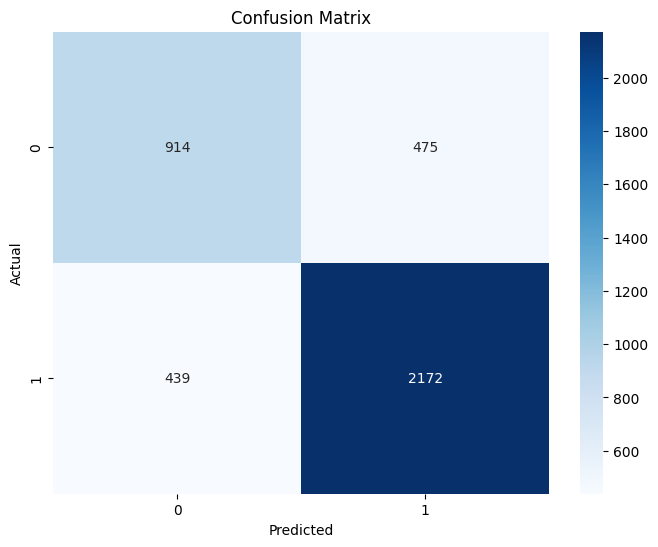

In [56]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)

# Gera a matriz de confusão
cm = confusion_matrix(y_test, y_pred)
# Exibe as métricas
print(classification_report(y_test, y_pred))

# Exibe a matriz de confusão
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


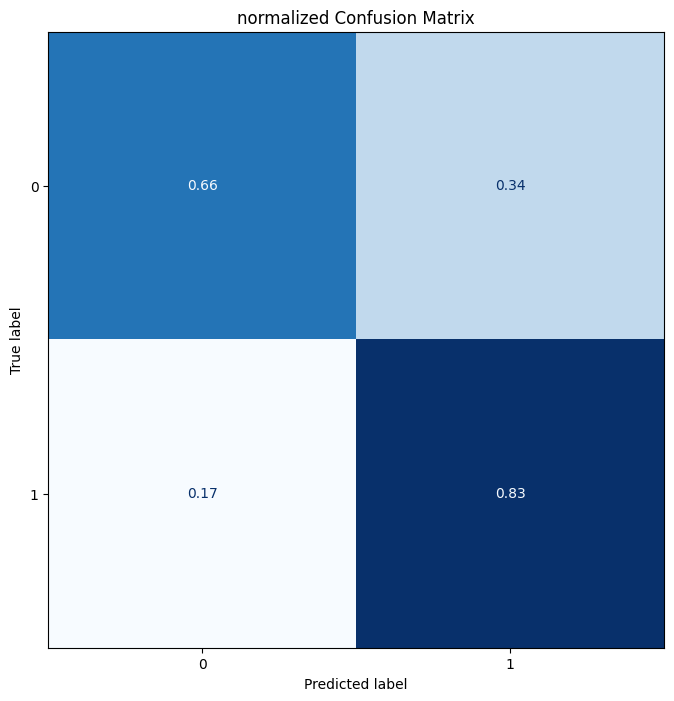

0.7715

In [57]:

cm=confusion_matrix(y_test,y_pred,normalize='true')
fig,ax = plt.subplots(figsize=(8,8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues',values_format='.2f',ax=ax,colorbar=False)
plt.title('normalized Confusion Matrix')
plt.show()

accuracy_score(y_test, y_pred)

In [64]:
model.save('adclick_model.keras')
model = load_model('adclick_model.keras')
model.summary()


e:\rna\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 26 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_18 (Dense)                │ (None, 46)             │         1,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 46)             │         2,162 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 46)             │         2,162 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 46)             │         2,162 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 46)             │         2,162 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 46)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │            47 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,537 (115.38 KB)

 Trainable params: 9,845 (38.46 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 19,692 (76.93 KB)

In [65]:
y_predi = model.predict(X_test)
random_idx = np.random.randint(0, X_test.shape[0])
linha_teste = X_test[random_idx].reshape(1, -1)  
predicao = model.predict(linha_teste)


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


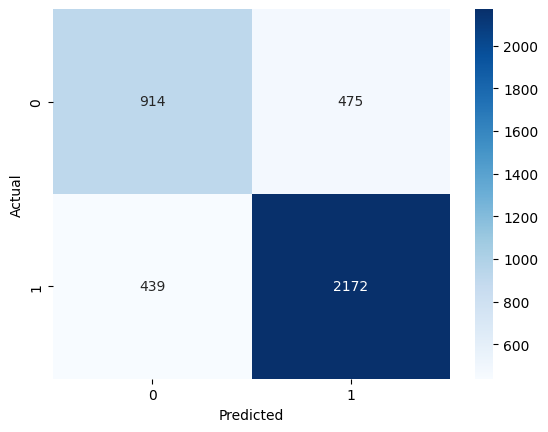

In [66]:
cm = confusion_matrix(y_test, y_predi.round())
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

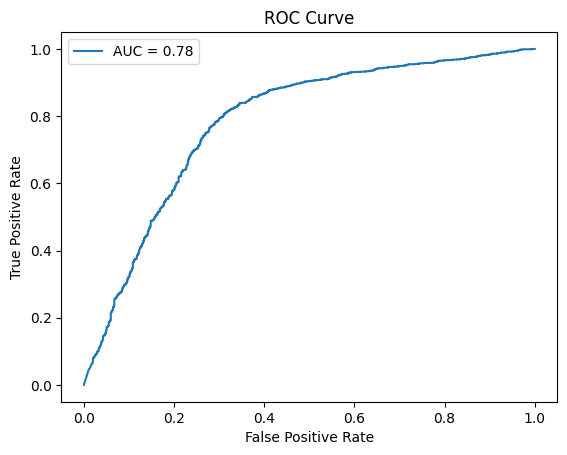

In [67]:
fpr, tpr, _ = roc_curve(y_test, y_predi)
plt.plot(fpr, tpr, label=f"AUC = {auc(fpr, tpr):.2f}")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

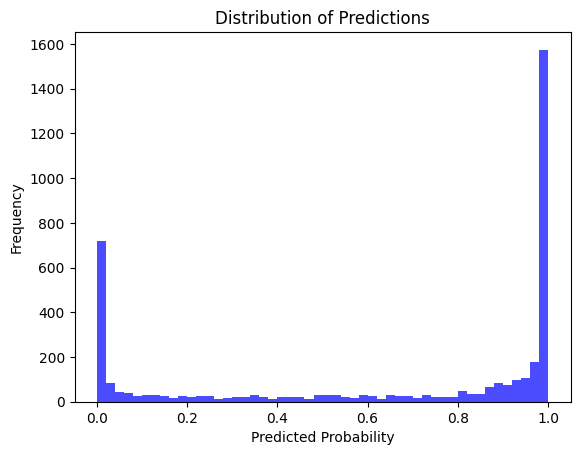

In [68]:
plt.hist(y_predi, bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Predictions')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.show()

In [69]:
random_idx = np.random.randint(0, X_test.shape[0])
new_input = X_test[random_idx].reshape(1, -1)  

predicao = model.predict(new_input)
predicted_class = 1 if predicao >= 0.5 else 0

original_class = y_test.iloc[random_idx]  

print(f"Classe prevista: {predicted_class}")
print(f"Classe original: {original_class}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Classe prevista: 0
Classe original: 0.0
